### Analyze the embeddings and calculate the "information content" preserved by the statements and theorem names.  
  1. 

In [1]:
from sklearn.metrics.pairwise import cosine_similarity as cs
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, bws_test
SAMPLE_SIZE=2000

In [2]:
import os
if not os.path.isdir("figures/analysis"):
    os.makedirs("figures/analysis")

In [2]:
iemb_both = np.load(f"data/embedded/isabelle_{SAMPLE_SIZE}_embed_both.npy")
iemb_statement = np.load(f"data/embedded/isabelle_{SAMPLE_SIZE}_embed_statement.npy")
iemb_name = np.load(f"data/embedded/isabelle_{SAMPLE_SIZE}_embed_name.npy")
iemb_original = np.load(f"data/embedded/isabelle_{SAMPLE_SIZE}_embed_original.npy")

In [3]:
np.unique(np.argmax(np.array([[cs([iemb_both[i]],[iemb_name[i]]), cs([iemb_both[i]],[iemb_statement[i]]),cs([iemb_name[i]],[iemb_statement[i]]), cs([iemb_both[i]],[iemb_original[i]])] for i in range(2000)]),axis=1), return_counts = True)

(array([0, 1, 2, 3]), array([ 414, 1443,   60,   83]))

This seems to indicate that the originals are <span style="color:red"> not much closer to our returned statement.</span> Let's check it out in Lean

In [4]:
lemb_both = np.load(f"data/embedded/lean_{SAMPLE_SIZE}_embed_both.npy")
lemb_statement = np.load(f"data/embedded/lean_{SAMPLE_SIZE}_embed_statement.npy")
lemb_name = np.load(f"data/embedded/lean_{SAMPLE_SIZE}_embed_name.npy")
lemb_original = np.load(f"data/embedded/lean_{SAMPLE_SIZE}_embed_original.npy")

In [5]:
np.unique(np.argmax(np.array([[cs([lemb_both[i]],[lemb_name[i]]), cs([lemb_both[i]],[lemb_statement[i]]),cs([lemb_name[i]],[lemb_statement[i]]), cs([lemb_both[i]],[lemb_original[i]])] for i in range(2000)]),axis=1), return_counts = True)

(array([0, 1, 2, 3]), array([829, 884, 131, 156]))

Looking at the data, I do now believe the inputs were constructed directly from gpt-4.0 using the prompt given. Why? Because no one does it say something like "In Lean" or "Sure". **The data is suspect.** 



In [6]:
i_sdata = np.array([[
    100*cs([iemb_both[i]],[iemb_name[i]])[0][0],100*cs([iemb_both[i]],[iemb_statement[i]])[0][0]] for i in range(2000)])
l_sdata = np.array([[
    100*cs([lemb_both[i]],[lemb_name[i]])[0][0],100*cs([lemb_both[i]],[lemb_statement[i]])[0][0]] for i in range(2000)])

In [7]:
np.unique(np.argmax(i_sdata,axis=1),return_counts=True),np.unique(np.argmax(l_sdata,axis=1),return_counts=True)

((array([0, 1]), array([ 451, 1549])), (array([0, 1]), array([ 933, 1067])))

In [8]:
np.mean(i_sdata,axis=0),np.mean(l_sdata,axis=0)

(array([68.48177276, 81.02866548]), array([73.51678631, 76.16816689]))

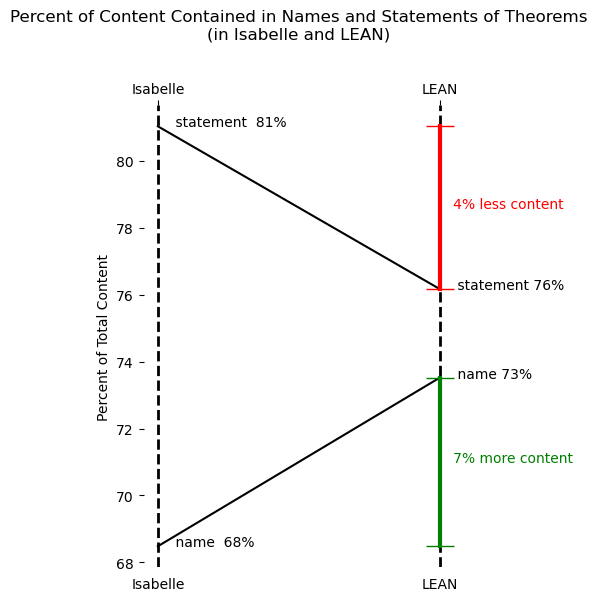

In [9]:
i_means = np.mean(i_sdata,axis=0)
l_means = np.mean(l_sdata,axis=0)
fig,ax = plt.subplots(figsize=(4,6))

plt.axvline(x="Isabelle", color="black", linestyle = "--",linewidth=2)
plt.axvline(x="LEAN", color="black", linestyle = "--",linewidth=2)

### Plot Lines
for y1,y2 in zip(i_means, l_means):
    line0, = plt.plot(["Isabelle","LEAN"], [y1,y2], color='black')

# ### Plot Points
# for value in i_means:
#     plt.plot("Isabelle", value, marker='o', color='blue', markersize=12)
# for value in l_means:
#     plt.plot("LEAN", value, marker='o', color='blue', markersize=12)

### Add labels
for index,label in enumerate(["name","statement"]):
    plt.text("Isabelle",i_means[index],f"    {label}  {int(i_means[index])}%")
    plt.text("LEAN",l_means[index],f"    {label} {int(l_means[index])}%")    

### Add Vertical Differences
line1, = plt.plot(["LEAN","LEAN"],[i_means[1],l_means[1]],marker = "_",color='red',markersize=20, linewidth=3)
plt.text("LEAN",i_means[1] - (i_means[1]-l_means[1])/2, f"   {int(i_means[1]-l_means[1])}% less content", color='red')

line2, = plt.plot(["LEAN","LEAN"],[i_means[0],l_means[0]],marker = "_",color='green',markersize=20, linewidth=3)
plt.text("LEAN",i_means[0] + (l_means[0]-i_means[0])/2, f"   {int(-i_means[0]+l_means[1])}% more content", color='green')

#plt.text("LEAN",i_means[0]+ .8*(l_means[0]-i_means[0])/2, f"         LEAN names have more content")

plt.title("Percent of Content Contained in Names and Statements of Theorems\n(in Isabelle and LEAN)\n\n")
plt.ylabel("Percent of Total Content")
plt.box(False)
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=True)
#plt.legend([line0,line1,line2],["change from Isabelle to LEAN","decrease","increase"],loc=(1.05, .05))

plt.savefig("figures/analysis/cosine_similarity_plt.jpg", bbox_inches="tight")

##### from scipy.stats import ttest_ind, bws_test

In [10]:
sd_df = pd.DataFrame({"itp":["isabelle"]*2000+["lean"]*2000,
                      "name":np.concatenate([i_sdata[:,0],l_sdata[:,0]]),
                      "statement":np.concatenate([i_sdata[:,1], l_sdata[:,1]]),
                      "ratio_sn":np.concatenate([i_sdata[:,1], l_sdata[:,1]])/np.concatenate([i_sdata[:,0],l_sdata[:,0]])})

In [11]:
sd_df.shape

(4000, 4)

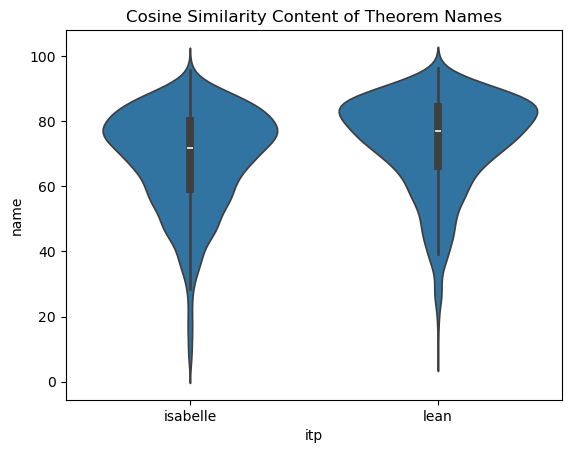

In [12]:
f= sns.violinplot(sd_df, x="itp", y="name").set(title="Cosine Similarity Content of Theorem Names")

[Text(0.5, 1.0, 'Cosine Similarity Values of Theorem Statement to Name+Statement')]

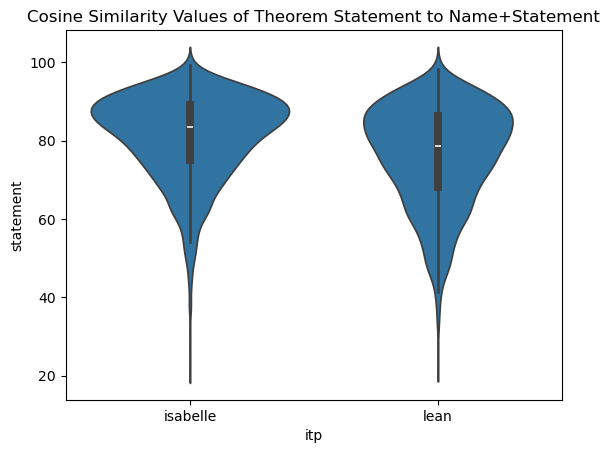

In [13]:
sns.violinplot(sd_df,x="itp",y="statement").set(title="Cosine Similarity Values of Theorem Statement to Name+Statement")

[Text(0.5, 1.0, 'Cosine Similarity Ratios of Statement to Name')]

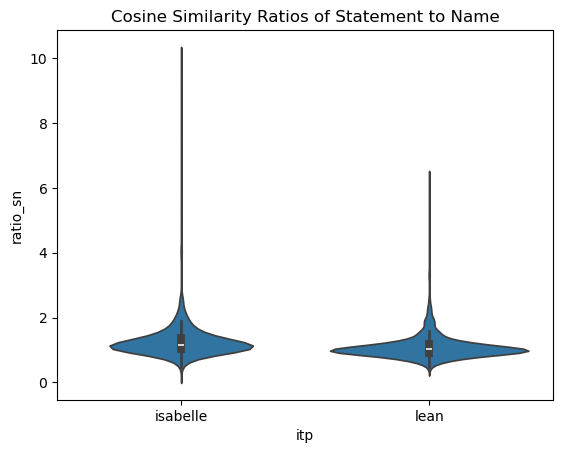

In [14]:
sns.violinplot(sd_df,x="itp",y="ratio_sn").set(title="Cosine Similarity Ratios of Statement to Name")

In [15]:
print("",
    ttest_ind(i_sdata[:,0], i_sdata[:,1], equal_var=False),"\n", 
    ttest_ind(l_sdata[:,0],l_sdata[:,1],equal_var=False),"\n",
    ttest_ind(i_sdata[:,0], l_sdata[:,0],equal_var=False),"\n", 
    ttest_ind(i_sdata[:,1],l_sdata[:,1],equal_var=False)
)
print("",
    bws_test(i_sdata[:,0], i_sdata[:,1]),"\n", 
    bws_test(l_sdata[:,0],l_sdata[:,1]),"\n",
    bws_test(i_sdata[:,0], l_sdata[:,0]),"\n", 
    bws_test(i_sdata[:,1],l_sdata[:,1])
)

 TtestResult(statistic=-29.932131287748785, pvalue=5.856742805255399e-176, df=3594.962006557197) 
 TtestResult(statistic=-6.145618512443026, pvalue=8.757712245290816e-10, df=3932.03053648984) 
 TtestResult(statistic=-10.676836599237616, pvalue=2.948136780504798e-26, df=3986.096130666753) 
 TtestResult(statistic=13.015898018311491, pvalue=6.079320469005526e-38, df=3895.9295788021655)
 PermutationTestResult(statistic=497.1552365380587, pvalue=0.0001, null_distribution=array([0.27615295, 1.01882504, 0.77666284, ..., 1.16998527, 2.81099634,
       0.48781807])) 
 PermutationTestResult(statistic=19.44873265241835, pvalue=0.0001, null_distribution=array([0.99163362, 0.55544687, 1.25085039, ..., 2.39326144, 1.01447929,
       0.34093899])) 
 PermutationTestResult(statistic=72.93683818982223, pvalue=0.0001, null_distribution=array([0.72080012, 0.27773413, 0.31088638, ..., 0.93129515, 0.89423942,
       0.46850644])) 
 PermutationTestResult(statistic=81.46329060788676, pvalue=0.0001, null_distr

In [16]:
idata = TSNE(2,perplexity=10).fit_transform(PCA(n_components=20).fit_transform(np.concatenate([iemb_statement, iemb_name, iemb_both])))

In [17]:
ldata = TSNE(2,perplexity=10).fit_transform(PCA(n_components=20).fit_transform(np.concatenate([lemb_statement, lemb_name, lemb_both])))

In [18]:
DATA = np.concatenate([idata, ldata])
DATA.shape

(12000, 2)

In [19]:
itp_data = pd.DataFrame({"x":DATA[:,0],"y":DATA[:,1],"itp":["Isabelle"]*6000 + ["LEAN"]*6000})

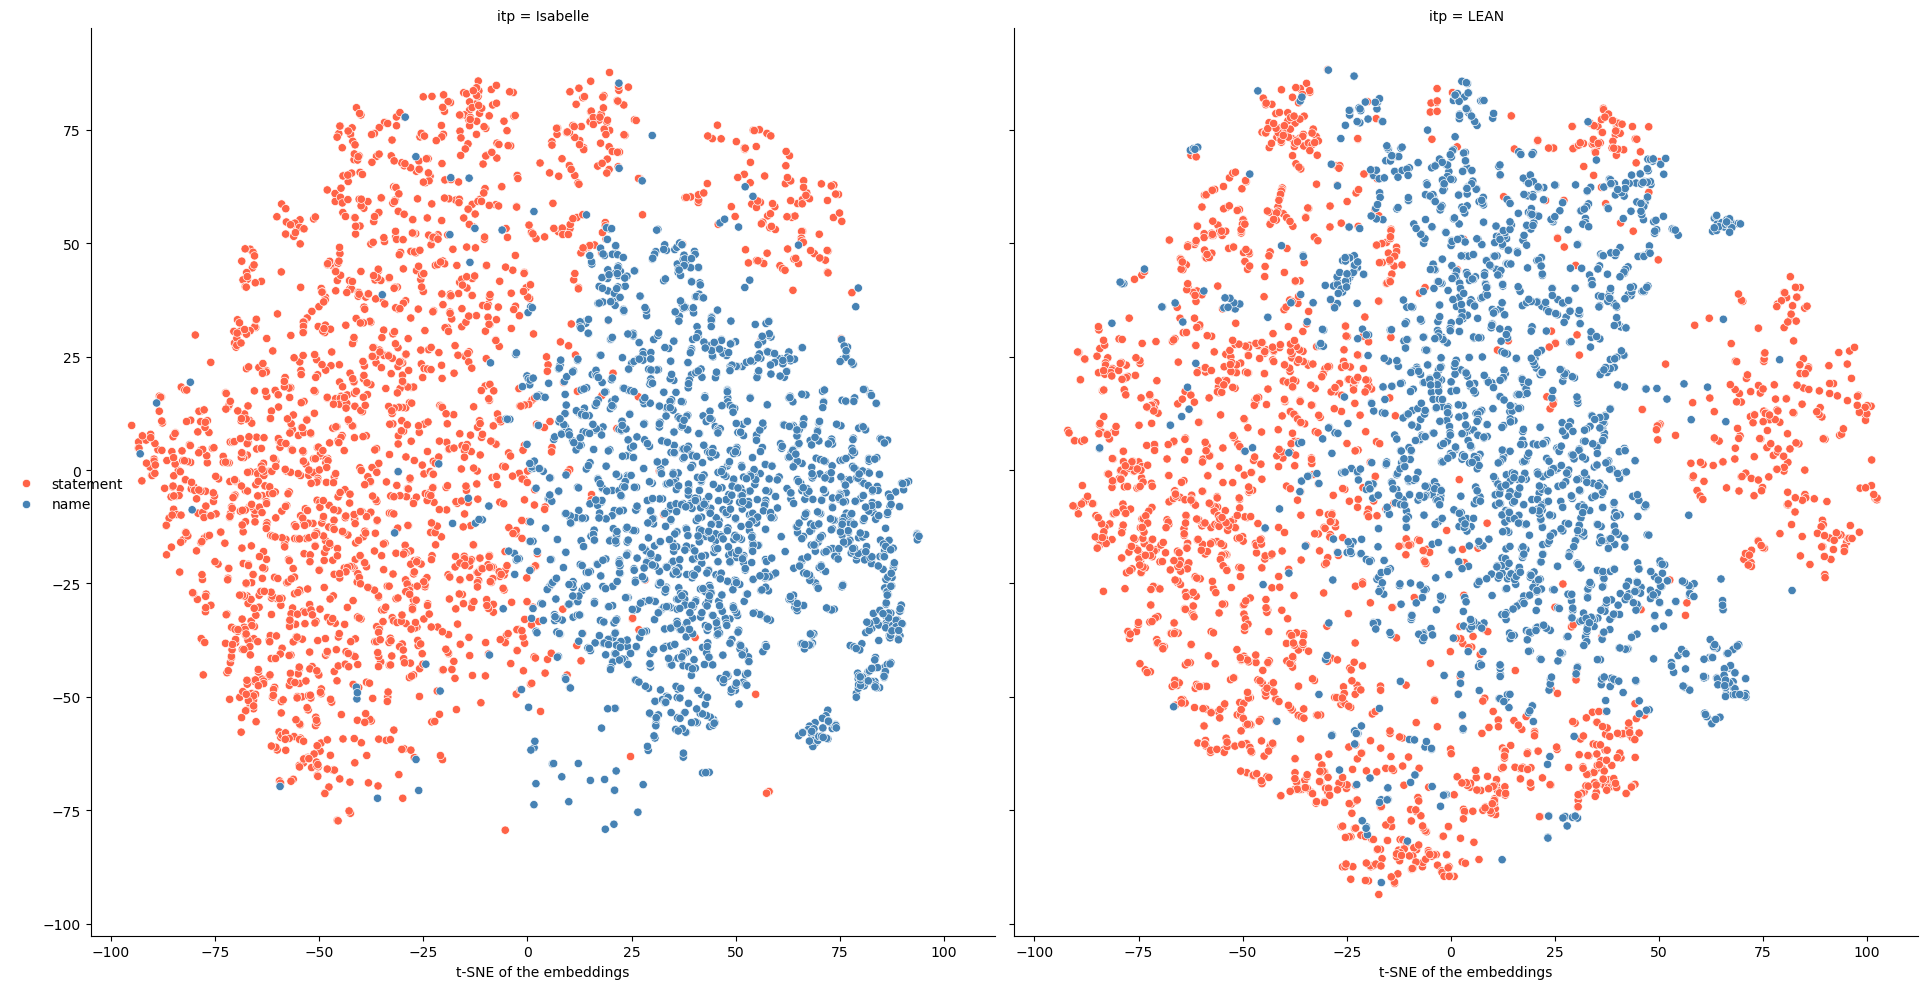

In [20]:
g = sns.FacetGrid(pd.concat([itp_data[:4000],itp_data[6000:10000]]), col="itp", margin_titles=True, height=10)
g.map(sns.scatterplot, "x", "y", 
      hue = ["statement"]*2000 + ["name"]*2000,# + ["both"]*2000,
      palette=['#FF6347', '#4682B4'],#, '#000000'],
      legend="full")
g.add_legend(loc="center left")
g.set_axis_labels("t-SNE of the embeddings", "")
g.savefig("figures/analysis/tsne_comparisions_state_name.jpg")

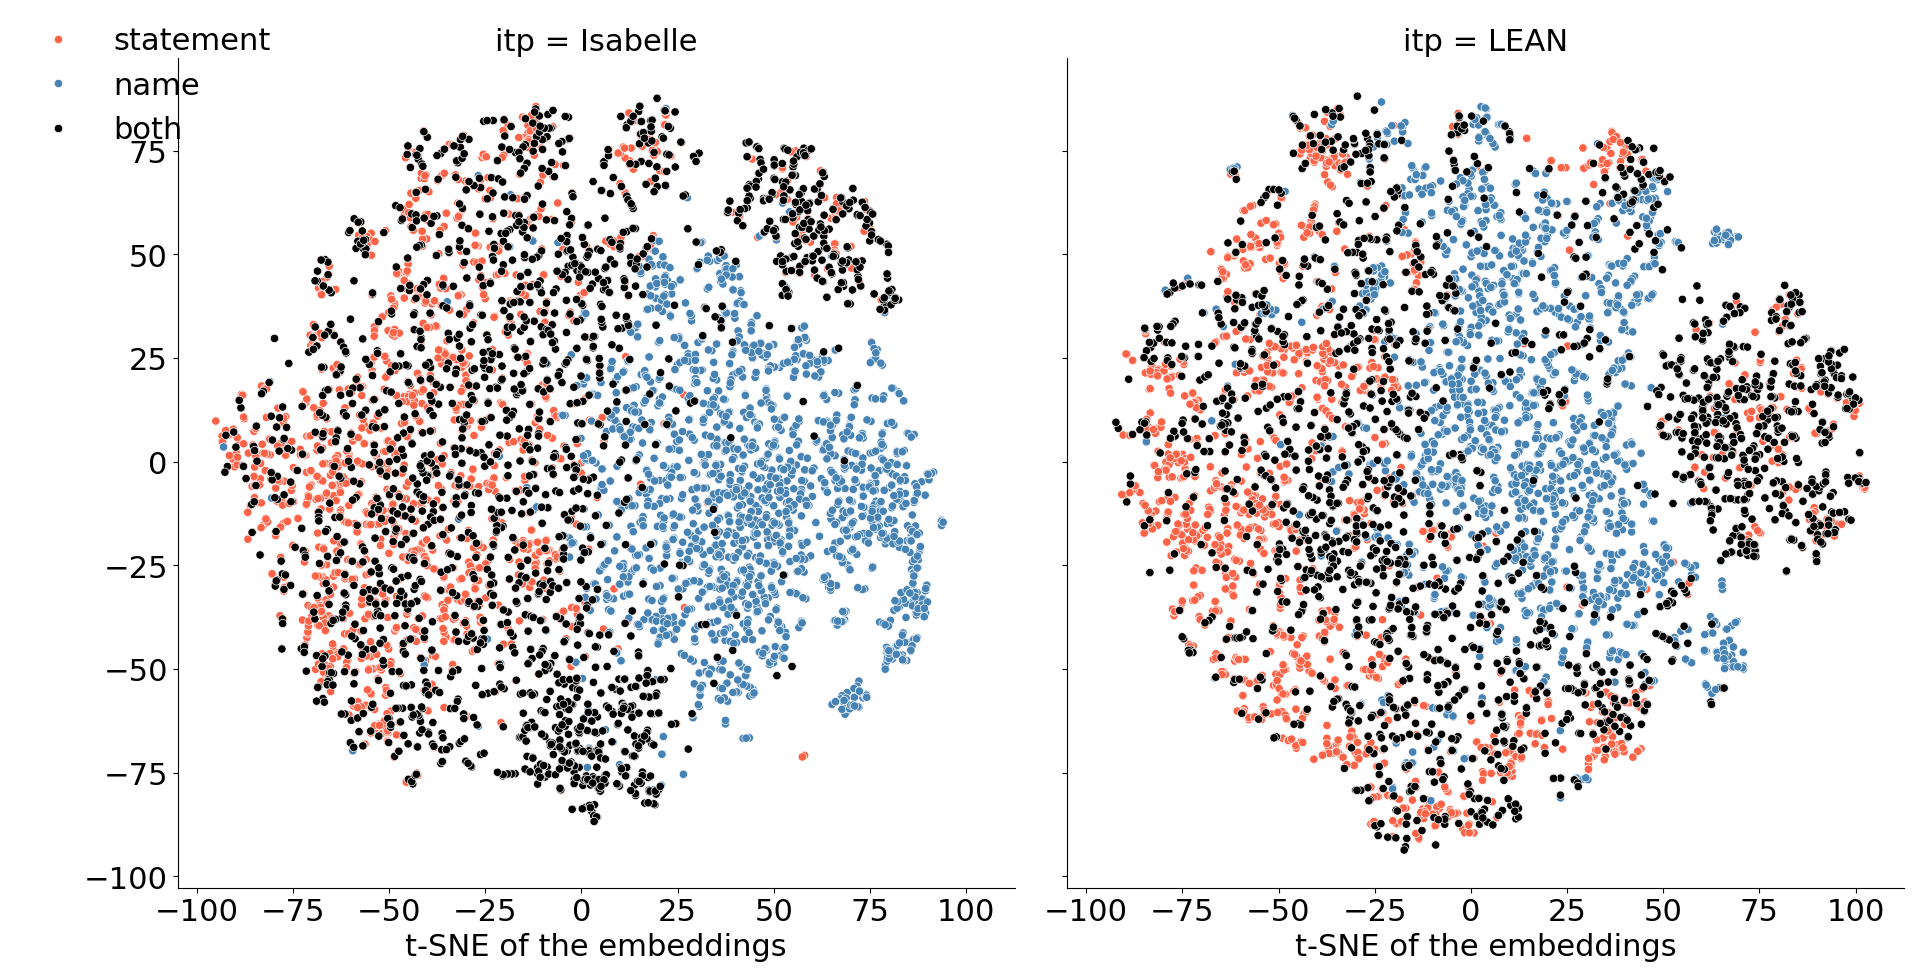

In [30]:
g = sns.FacetGrid(itp_data, col="itp", margin_titles=True, height=10)
g.map(sns.scatterplot, "x", "y", 
      hue = ["statement"]*2000 + ["name"]*2000 + ["both"]*2000,
      palette=['#FF6347', '#4682B4', '#000000'],
      legend="full")
g.add_legend(loc="upper left")
plt.rcParams.update({'font.size': 22})
g.set_axis_labels("t-SNE of the embeddings", "")
g.savefig("figures/analysis/tsne_comparisions_state_name_both.jpg")